# Neurodynamics Simulation

**Contents**

- [brainpy.NeuGroup](#brainpy.NeuGroup)
- [brainpy.TwoEndConn](#brainpy.TwoEndConn)
- [brainpy.Network](#brainpy.Network)
- [brainpy.connect module](#brainpy.connect-module)

For brain modeling, BrainPy provides the interface of `brainpy.NeuGroup`, `brainpy.TwoEndConn`, and `brainpy.Network` for convenient neurodynamics simulation.

In [1]:
import brainpy as bp
import numpy as np

## brainpy.NeuGroup

`brainpy.NeuGroup` is used for neuron group modeling. User-defined neuron group models must inherit from the `brainpy.NeuGroup`. Let's take the [leaky integrate-and-fire](https://en.wikipedia.org/wiki/Biological_neuron_model#Leaky_integrate-and-fire) (LIF) model and [Hodgkin–Huxley neuron model](https://en.wikipedia.org/wiki/Hodgkin%E2%80%93Huxley_model) as the illustrated examples. 

### LIF model

The formal equations of a LIF model is given by:

$$
\tau_m \frac{dV}{dt} = - (V(t) - V_{rest}) + I(t) 
\\
\text{after}\, V(t) \gt V_{th}, V(t) =V_{rest}
\,
\text{last}\, \tau_{ref}\, \text{ms} 
$$

where $V$ is the membrane potential, $V_{rest}$ is the rest membrane potential, $V_{th}$ is the spike threshold, $\tau_m$ is the time constant, $\tau_{ref}$ is the refractory time period, and $I$ is the time-variant synaptic inputs. 

As stated above, the numerical integration of the differential equation in LIF model can be coded as:

In [2]:
@bp.odeint
def int_V(V, t, Iext, V_rest, R, tau):
    return (- (V - V_rest) + R * Iext) / tau

Then, we will define the following items to store the neuron state:

- ``V``: The membrane potential.
- ``input``: The synaptic input.
- ``spike``: Whether produce a spike.
- ``refractory``: Whether the neuron is in refractory state.
- ``t_last_spike``: The last spike time for calculating refractory state.

Based on these states, the updating logic of LIF model from the current time $t$ to the next time $t+dt$ will be coded as:

In [3]:
class LIF(bp.NeuGroup):
    target_backend = ['numpy', 'numba']

    def __init__(self, size, t_refractory=1., V_rest=0.,
                 V_reset=-5., V_th=20., R=1., tau=10., **kwargs):
        # parameters
        self.V_rest = V_rest
        self.V_reset = V_reset
        self.V_th = V_th
        self.R = R
        self.tau = tau
        self.t_refractory = t_refractory

        # variables
        self.t_last_spike = bp.backend.ones(size) * -1e7
        self.refractory = bp.backend.zeros(size)
        self.input = bp.backend.zeros(size)
        self.spike = bp.backend.zeros(size)
        self.V = bp.backend.ones(size) * V_reset

        super(LIF, self).__init__(size=size, **kwargs)
    
    @staticmethod
    @bp.odeint
    def int_V(V, t, Iext, V_rest, R, tau):
        return (- (V - V_rest) + R * Iext) / tau
    
    def update(self, _t):
        for i in range(self.size[0]):
            if _t - self.t_last_spike[i] <= self.t_refractory:
                self.refractory[i] = 1.
            else:
                self.refractory[0] = 0.
                V = self.int_V(self.V[i], _t, self.input[i], self.V_rest, self.R, self.tau)
                if V >= self.V_th:
                    self.V[i] = self.V_reset
                    self.spike[i] = 1.
                    self.t_last_spike[i] = _t
                else:
                    self.spike[i] = 0.
                    self.V[i] = V
            self.input[i] = 0.

That's all, we have coded a LIF neuron model. 

Each NeuGroup has a powerful function: ``.run()``. In this function, it receives the following arguments:

- ``duration``: Specify the simulation duration. Can be a tuple with ``(start time, end time)``. Or it can be a int to specify the duration ``length`` (then the default start time is ``0``).
- ``inputs``: Specify the inputs for each model component. With the format of ``(target, value, [operation])``. The default operation is ``+``, which means the input ``value`` will be added to the ``target``. Or, the operation can be ``-``, ``*``, ``/``, or ``=``.

Now, let's run it.

In [4]:
group = LIF(100, monitors=['V'])

Compilation used 0.0011 s.
Start running ...
Run 10.0% used 0.091 s.
Run 20.0% used 0.167 s.
Run 30.0% used 0.259 s.
Run 40.0% used 0.334 s.
Run 50.0% used 0.408 s.
Run 60.0% used 0.473 s.
Run 70.0% used 0.538 s.
Run 80.0% used 0.605 s.
Run 90.0% used 0.680 s.
Run 100.0% used 0.747 s.
Simulation is done in 0.747 s.



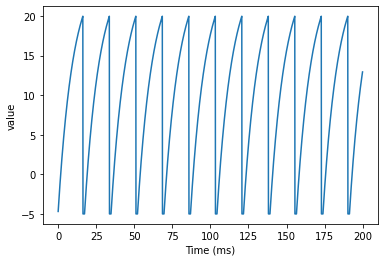

In [5]:
group.run(duration=200., inputs=('input', 26.), report=True)
bp.visualize.line_plot(group.mon.ts, group.mon.V, show=True)

Compilation used 0.0000 s.
Start running ...
Run 10.0% used 0.074 s.
Run 20.0% used 0.148 s.
Run 30.0% used 0.219 s.
Run 40.0% used 0.283 s.
Run 50.0% used 0.367 s.
Run 60.0% used 0.452 s.
Run 70.0% used 0.520 s.
Run 80.0% used 0.588 s.
Run 90.0% used 0.656 s.
Run 100.0% used 0.735 s.
Simulation is done in 0.735 s.



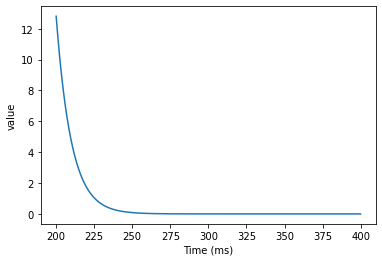

In [6]:
group.run(duration=(200, 400.), report=True)
bp.visualize.line_plot(group.mon.ts, group.mon.V, show=True)

As you experenced just now, the benifit of inheriting `brainpy.NeuGroup` lies at the following several ways:

- Easy way to monitor variable trajectories.
- Powerfull "inputs" support.
- Continuous running support. 
- Progress report support. 

On the model definition, BrainPy endows you the fully data/logic flow control. You can define models with any data you need and any logic you want. There are little limitations/constrains on your customization. 1, you should set what computing backend do your defined model support by the keyword `target_backend`. 2, you should "super()" initialize the `brainpy.NeuGroup` with the keyword of the group `size`. 3, you should define the `update` function.

### Hodgkin–Huxley model

The updating logic in the above LIF model is coded with a for loop, which is very suitable for Numba backend (because Numba is a Just-In-Time compiler, and it is good at the for loop optimization). However, for array-oriented programming languages, such as NumPy, PyTorch and TensorFlow, this coding schema is inefficient. Here, let's use the HH neuron model as example to demonstrate how to code an array-based neuron model for general backends.

In [7]:
class HH(bp.NeuGroup):
    target_backend = 'general'

    def __init__(self, size, ENa=50., EK=-77., EL=-54.387,
                 C=1.0, gNa=120., gK=36., gL=0.03, V_th=20.,
                 **kwargs):
        # parameters
        self.ENa = ENa
        self.EK = EK
        self.EL = EL
        self.C = C
        self.gNa = gNa
        self.gK = gK
        self.gL = gL
        self.V_th = V_th

        # variables
        self.V = bp.backend.ones(size) * -65.
        self.m = bp.backend.ones(size) * 0.5
        self.h = bp.backend.ones(size) * 0.6
        self.n = bp.backend.ones(size) * 0.32
        self.spike = bp.backend.zeros(size)
        self.input = bp.backend.zeros(size)
        
        def diff(V, m, h, n, t, Iext, gNa, ENa, gK, EK, gL, EL, C):
            alpha = 0.1 * (V + 40) / (1 - bp.backend.exp(-(V + 40) / 10))
            beta = 4.0 * bp.backend.exp(-(V + 65) / 18)
            dmdt = alpha * (1 - m) - beta * m

            alpha = 0.07 * bp.backend.exp(-(V + 65) / 20.)
            beta = 1 / (1 + bp.backend.exp(-(V + 35) / 10))
            dhdt = alpha * (1 - h) - beta * h

            alpha = 0.01 * (V + 55) / (1 - bp.backend.exp(-(V + 55) / 10))
            beta = 0.125 * bp.backend.exp(-(V + 65) / 80)
            dndt = alpha * (1 - n) - beta * n

            I_Na = (gNa * m ** 3.0 * h) * (V - ENa)
            I_K = (gK * n ** 4.0) * (V - EK)
            I_leak = gL * (V - EL)
            dVdt = (- I_Na - I_K - I_leak + Iext) / C

            return dVdt, dmdt, dhdt, dndt
        
        self.integral = bp.odeint(f=diff, method='rk4', dt=0.01)
        
        super(HH, self).__init__(size=size, **kwargs)

    def update(self, _t):
        V, m, h, n = self.integral(self.V, self.m, self.h, self.n, _t,
                                   self.input, self.gNa, self.ENa, self.gK,
                                   self.EK, self.gL, self.EL, self.C)
        self.spike = (self.V < self.V_th) * (V >= self.V_th)
        self.V = V
        self.m = m
        self.h = h
        self.n = n
        self.input[:] = 0

In HH example, all the operations (including "zeros", "ones" and "exp") are used from the `brainpy.backend` as `bp.backend.zeros`, `bp.backend.ones` and `bp.backend.exp`. What's more, we set the "target_backend" as `general`. So, let's try to run this model on various backends.

First is PyTorch.

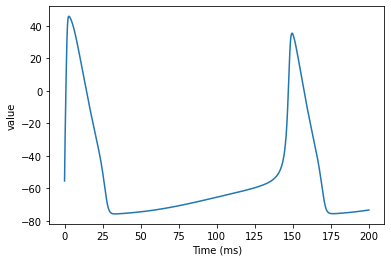

In [8]:
bp.backend.set('pytorch')

group = HH(100, monitors=['V'])
group.run(200., inputs=('input', 10.))
bp.visualize.line_plot(group.mon.ts, group.mon.V, show=True)

Second is NumPy.

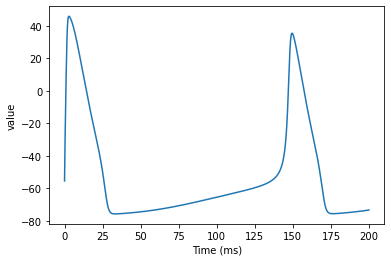

In [9]:
bp.backend.set('numpy')

group = HH(100, monitors=['V'])
group.run(200., inputs=('input', 10.))
bp.visualize.line_plot(group.mon.ts, group.mon.V, show=True)

The last is Numba.

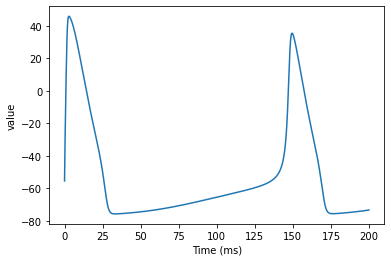

In [10]:
bp.backend.set('numba')

group = HH(100, monitors=['V'])
group.run(200., inputs=('input', 10.))
bp.visualize.line_plot(group.mon.ts, group.mon.V, show=True)

## brainpy.TwoEndConn

For synaptic connections, BrainPy provides `brainpy.TwoEndConn` to help you construct the projection between pre-synaptic and post-synaptic neuron groups, and provides `brainpy.connect.Connector` for synaptic connectivity between pre- and post- groups. 

- The benifit of using `brainpy.TwoEndConn` lies at the **automatical synaptic delay**. The synapse modeling usually includes a delay time (typically 0.3–0.5 ms) required for a neurotransmitter to be released from a presynaptic membrane, diffuse across the synaptic cleft, and bind to a receptor site on the post-synaptic membrane. BrainPy provides `register_constant_dely()` for automatical state delay. 

- The benifit of using `brainpy.connect.Connector` lies at the **connectivity structure construction**. `brainpy.connect.Connector` provides various synaptic structures, like "pre_ids", "post_ids", "conn_mat", "pre2post", "post2pre", "pre2syn", "post2syn", "pre_slice_syn", and "post_slice_syn". Users can "requires" such data structures by calling `connector.requires('pre_ids', 'post_ids', ...)`.

Here, let's illustrate this by the AMPA synapse model.

### AMPA Synapse Model

In [11]:
class AMPA(bp.TwoEndConn):
    target_backend = ['numpy', 'numba']

    def __init__(self, pre, post, conn, delay=0., g_max=0.10, E=0., tau=2.0, **kwargs):
        # parameters
        self.g_max = g_max
        self.E = E
        self.tau = tau
        self.delay = delay

        # connections
        self.conn = conn(pre.size, post.size)
        self.conn_mat = conn.requires('conn_mat')
        self.size = bp.backend.shape(self.conn_mat)

        # variables
        self.s = bp.backend.zeros(self.size)
        self.g = self.register_constant_delay('g', size=self.size, delay_time=delay)

        super(AMPA, self).__init__(pre=pre, post=post, **kwargs)

    @staticmethod
    @bp.odeint(dt=0.01)
    def int_s(s, t, tau):
        return - s / tau

    def update(self, _t):
        self.s = self.int_s(self.s, _t, self.tau)
        for i in range(self.pre.size[0]):
            if self.pre.spike[i] > 0:
                self.s[i] += self.conn_mat[i]
        self.g.push(self.g_max * self.s)
        g = self.g.pull()
        self.post.input -= bp.backend.sum(g, axis=0) * (self.post.V - self.E)

To define a two-end projection synapse is very much like the NeuGroup. Users need to inherit the `brainpy.TwoEndConn`, and provide the "target_backend" specification, "update" function and then "super()" initialize the parent class. But what different are two aspects: 1. connection. We need construct the synaptic connectivity by "connector.requires". 2. delay. We can register a constant delay variable by "self.register_constant_delay()".

Here, we create a matrix-based connectivity (with the shape of `(num_pre, num_post)`). 

<img src="../images/syn-example-conn_mat.png" width="400 px" align="left">

And then register a delay variable "self.g" with the shape of `(num_pre, num_post)`.

## brainpy.Network

Now, let's put the above defined HH model and AMPA synapse together to construct a network with `brainpy.Network`.

In [12]:
bp.backend.set('numpy')

In [13]:
group = HH(10, monitors=['V', 'spike'])
syn = AMPA(pre=group, post=group, conn=bp.connect.All2All(), delay=1.5, monitors=['s'])

In [14]:
net = bp.Network(group, syn)
net.run(duration=200., inputs=(group, "input", 20.), report=True)

Compilation used 0.8206 s.
Start running ...
Run 10.0% used 0.188 s.
Run 20.0% used 0.342 s.
Run 30.0% used 0.506 s.
Run 40.0% used 0.643 s.
Run 50.0% used 0.771 s.
Run 60.0% used 0.896 s.
Run 70.0% used 1.098 s.
Run 80.0% used 1.282 s.
Run 90.0% used 1.431 s.
Run 100.0% used 1.585 s.
Simulation is done in 1.585 s.



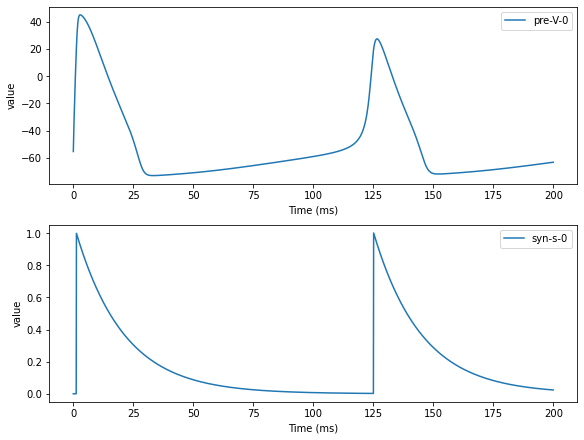

In [15]:
fig, gs = bp.visualize.get_figure(2, 1, 3, 8)

fig.add_subplot(gs[0, 0])
bp.visualize.line_plot(group.mon.ts, group.mon.V, legend='pre-V')

fig.add_subplot(gs[1, 0])
bp.visualize.line_plot(syn.mon.ts, syn.mon.s, legend='syn-s', show=True)

## brainpy.connect module

BrainPy provides several commonly used connection methods in ``brainpy.connect`` module (see the follows). They are all inherited from the base class `brainpy.connect.Connector`. Users can also customize their synaptic connectivity by class inheritance. 

### brainpy.connect.One2One

The neurons in the pre-synaptic neuron group only connect to the neurons
in the same position of the post-synaptic group. Thus, this connection
requires the indices of two neuron groups same. Otherwise, an error will
occurs.

<img src="../images/one2one.png" width="200 px" align="left">

### brainpy.connect.All2All

All neurons of the post-synaptic population form connections with all
neurons of the pre-synaptic population (dense connectivity). Users can
choose whether connect the neurons at the same position
(`include_self=True or False`).

<img src="../images/all2all.png" width="200 px" align="left">

### brainpy.connect.GridFour

`GridFour` is the four nearest neighbors connection. Each neuron connect to its
nearest four neurons.

<img src="../images/grid_four.png" width="250 px" align="left">

### brainpy.connect.GridEight

`GridEight` is eight nearest neighbors connection. Each neuron connect to its
nearest eight neurons.

<img src="../images/grid_eight.png" width="250 px" align="left">

### brainpy.connect.GridN

`GridN` is also a nearest neighbors connection. Each neuron connect to its
nearest $2N \cdot 2N$ neurons.

<img src="../images/grid_N.png" width="250 px" align="left">

### brainpy.connect.FixedProb

For each post-synaptic neuron, there is a fixed probability that it forms a connection
with a neuron of the pre-synaptic population. It is basically a all_to_all projection,
except some synapses are not created, making the projection sparser.

<img src="../images/fixed_proab.png" width="200 px" align="left">

### brainpy.connect.FixedPreNum

Each neuron in the post-synaptic population receives connections from a
fixed number of neurons of the pre-synaptic population chosen randomly.
It may happen that two post-synaptic neurons are connected to the same
pre-synaptic neuron and that some pre-synaptic neurons are connected to
nothing.

<img src="../images/fixed_pre_num.png" width="200 px" align="left">

### brainpy.connect.FixedPostNum

Each neuron in the pre-synaptic population sends a connection to a fixed number of neurons
of the post-synaptic population chosen randomly. It may happen that two pre-synaptic neurons
are connected to the same post-synaptic neuron and that some post-synaptic neurons receive
no connection at all.

<img src="../images/fixed_post_num.png" width="200 px" align="left">

### brainpy.connect.GaussianProb


Builds a Gaussian connection pattern between the two populations, where
the connection probability decay according to the gaussian function.

Specifically,

$$
p=\exp(-\frac{(x-x_c)^2+(y-y_c)^2}{2\sigma^2})
$$

where $(x, y)$ is the position of the pre-synaptic neuron
and $(x_c,y_c)$ is the position of the post-synaptic neuron.

For example, in a $30 \textrm{x} 30$ two-dimensional networks, when
$\beta = \frac{1}{2\sigma^2} = 0.1$, the connection pattern is shown
as the follows:

<img src="../images/gaussian_prob.png" width="500 px" align="left">

### brainpy.connect.GaussianWeight

Builds a Gaussian connection pattern between the two populations, where
the weights decay with gaussian function.

Specifically,

$$w(x, y) = w_{max} \cdot \exp(-\frac{(x-x_c)^2+(y-y_c)^2}{2\sigma^2})$$

where $(x, y)$ is the position of the pre-synaptic neuron (normalized
to [0,1]) and $(x_c,y_c)$ is the position of the post-synaptic neuron
(normalized to [0,1]), $w_{max}$ is the maximum weight. In order to void
creating useless synapses, $w_{min}$ can be set to restrict the creation
of synapses to the cases where the value of the weight would be superior
to $w_{min}$. Default is $0.01 w_{max}$.


In [16]:
import matplotlib.pyplot as plt

def show_weight(pre_ids, post_ids, weights, geometry, neu_id):
    height, width = geometry
    ids = np.where(pre_ids == neu_id)[0]
    post_ids = post_ids[ids]
    weights = weights[ids]

    X, Y = np.arange(height), np.arange(width)
    X, Y = np.meshgrid(X, Y)
    Z = np.zeros(geometry)
    for id_, weight in zip(post_ids, weights):
        h, w = id_ // width, id_ % width
        Z[h, w] = weight

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

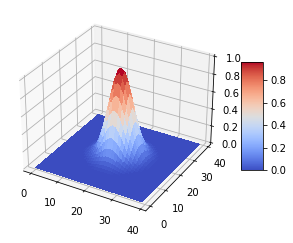

In [17]:
gaussian_weight = bp.connect.GaussianWeight(
    sigma=0.1, w_max=1., w_min=0.01,
    normalize=True, include_self=True)
pre_geom = post_geom = (40, 40)
gaussian_weight(pre_geom, post_geom)

pre_ids = gaussian_weight.pre_ids
post_ids = gaussian_weight.post_ids
weights = gaussian_weight.weights
show_weight(pre_ids, post_ids, weights, pre_geom, 820)

### brainpy.connect.DOG


Builds a Difference-Of-Gaussian (dog) connection pattern between the two populations.

Mathematically,

$$
w(x, y) = w_{max}^+ \cdot \exp(-\frac{(x-x_c)^2+(y-y_c)^2}{2\sigma_+^2})
    - w_{max}^- \cdot \exp(-\frac{(x-x_c)^2+(y-y_c)^2}{2\sigma_-^2})
$$

where weights smaller than $0.01 * abs(w_{max} - w_{min})$ are not created and
self-connections are avoided by default (parameter allow_self_connections).


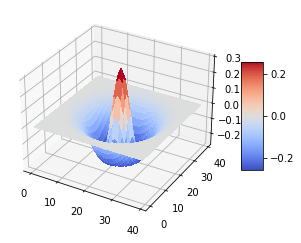

In [18]:
dog = bp.connect.DOG(
    sigmas=(0.08, 0.15),
    ws_max=(1.0, 0.7), w_min=0.01,
    normalize=True, include_self=True)
h = 40
pre_geom = post_geom = (h, h)
dog(pre_geom, post_geom)

pre_ids = dog.pre_ids
post_ids = dog.post_ids
weights = dog.weights
show_weight(pre_ids, post_ids, weights, (h, h), h * h // 2 + h // 2)